# Impact of bit collisions on learning performance: screening data

This is the second in series of posts looking at how changing fingerprint length (and thus the number of bit collisions) affects machine learning performance. The [first post in the series](https://greglandrum.github.io/rdkit-blog/posts/2022-12-25-colliding-bits-ii-revisited.html) worked with data sets constructed from ChEMBL where the training set is a small number of related actives and a set of diverse assumed decoys; the validation set was a more diverse set of actives and more diverse assumed decoys. Here we look at a collection of data sets with a very different character: high-throughput screening data sets from PubChem BioAssay (PCBA).

# The data sets

Rather than curating the datasets from PubChem myself, here I will use the pre-curated sets which were published by Rognan's group in Strasbourg group as ["LIT-PCBA"](https://doi.org/10.1021/acs.jcim.0c00155). The data can be downloaded [here](https://drugdesign.unistra.fr/LIT-PCBA/). There are two collections of data sets here: 

1. the "full" PCBA data sets : these are curated collections of measured active and inactive compounds from PCBA screens against 15 protein targets.
2. the "LIT-PCBA" data sets : these are the main point of the paper and consistent of "unbiased" training/validation splits of the full PCBA data for those 15 screens. There's considerably more detail about this in the paper.

I'm generally more interested in the results from the real data sets than the "unbiased" forms, but I'll present results for both here. I treat them both a bit differently.

Since some of the data sets are quite big - tens to hundreds of thousands of inactives - in every case I subset the inactives by randomly selecting either 10K inactives or 100 * the number of actives, whichever is smaller.

For the analysis of the full data sets, I dropped any of the data sets which contain less than 50 actives; this drops 5 of the targets, leaving us with 10. I split this into training and validation sets using a random stratified 80/20 split. 

The LIT-PCBA data sets provide training/validation splits, so I used those.

# Algorithms and fingerprints

The fingerprints examined here:
1. MFP2: Morgan fingerprint, radius = 2
2. MFP3: Morgan fingerprint, radius = 3
3. RDK5: RDKit fingerprint, max path length = 5
4. HashAP: atom pairs, using [count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)
5. HashTT: topological torsions, [using count simulation](https://www.rdkit.org/docs/RDKit_Book.html#atom-pair-and-topological-torsion-fingerprints)

I considered 1K, 8K, and 16K (actually 16394 bits due to a typo in the code... *sigh*) versions of each fingerprint type.

The learning algorithms:
1. LMNB: Laplacian Naive Bayes, [NIBR implementation](https://github.com/rdkit/lmnb)
2. RF: random forest, sklearn implementation
3. BRF: balanced random forest, [imbalanced-learn implementation](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html)
4. XGB: extreme gradient boosting, [XGBoost implementation](https://xgboost.readthedocs.io/en/stable/python/python_intro.html)

Due to the larger datasets and my lack of patience, I've dropped logistic regression and the sklearn Naive Bayes classifier I looked at in the [first post in the series](https://greglandrum.github.io/rdkit-blog/posts/2022-12-25-colliding-bits-ii-revisited.html). I may come back and add these at some point.


# Results summary

Here's a summary of the comparison of the 1K and 16K fingerprints using AUC as a metric (there's an table at the bottom with other metrics).
The `result` column indicates whether the AUC value for the short fingerprint is usually less than (`lt`), the same as `same`, or greater than (`gt`) the AUC value for the long fingerprint. The `P` column provides the P value for the difference (assessed using scipy's [Wilcoxon signed-rank test](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html). The threshold for significance used was 0.01. The `delt` column has the median difference between the short-fingerprint AUC and long-fingerprint AUC. The `pct_delt` column indicates the median percentage change in AUC relative to the short-fingerprint AUC.

## Full data sets

| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 0.000977 | -0.035 | -0.0435 |
| lmnb | mfp3 | roc_auc_score | lt | 0.000977 | -0.048 | -0.0584 |
| lmnb | rdk5 | roc_auc_score | same | 0.695 | -0.0071 | -0.0088 |
| lmnb | hashap | roc_auc_score | same | 0.0371 | -0.011 | -0.0136 |
| lmnb | hashtt | roc_auc_score | lt | 0.00488 | -0.043 | -0.0566 |
| rf | mfp2 | roc_auc_score | same | 0.492 | 0.0042 | 0.00537 |
| rf | mfp3 | roc_auc_score | same | 0.625 | 0.0035 | 0.00368 |
| rf | rdk5 | roc_auc_score | same | 0.375 | 0.0055 | 0.00687 |
| rf | hashap | roc_auc_score | lt | 0.00195 | -0.015 | -0.0178 |
| rf | hashtt | roc_auc_score | same | 0.77 | -0.0016 | -0.00263 |
| brf | mfp2 | roc_auc_score | same | 0.322 | 0.0045 | 0.00562 |
| brf | mfp3 | roc_auc_score | same | 0.375 | -0.0021 | -0.00258 |
| brf | rdk5 | roc_auc_score | same | 0.105 | 0.014 | 0.0152 |
| brf | hashap | roc_auc_score | same | 0.375 | -0.012 | -0.0163 |
| brf | hashtt | roc_auc_score | same | 0.492 | 0.0042 | 0.00477 |
| xgb | mfp2 | roc_auc_score | same | 0.625 | -0.0036 | -0.0042 |
| xgb | mfp3 | roc_auc_score | same | 0.0371 | -0.018 | -0.0217 |
| xgb | rdk5 | roc_auc_score | same | 0.625 | -0.0032 | -0.00386 |
| xgb | hashap | roc_auc_score | same | 0.322 | -0.022 | -0.0244 |
| xgb | hashtt | roc_auc_score | same | 0.432 | -0.028 | -0.0342 |

## LIT-PCBA data sets

| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 9.16e-05 | -0.041 | -0.0532 |
| lmnb | mfp3 | roc_auc_score | lt | 0.00623 | -0.03 | -0.0382 |
| lmnb | rdk5 | roc_auc_score | same | 0.89 | 0.0012 | 0.00145 |
| lmnb | hashap | roc_auc_score | same | 0.252 | -0.013 | -0.0202 |
| lmnb | hashtt | roc_auc_score | lt | 0.00214 | -0.044 | -0.0565 |
| rf | mfp2 | roc_auc_score | same | 0.639 | 0.0031 | 0.00335 |
| rf | mfp3 | roc_auc_score | same | 0.978 | -0.0036 | -0.00508 |
| rf | rdk5 | roc_auc_score | same | 0.169 | 0.022 | 0.0281 |
| rf | hashap | roc_auc_score | same | 0.208 | -0.018 | -0.0218 |
| rf | hashtt | roc_auc_score | same | 0.561 | 0.002 | 0.00389 |
| brf | mfp2 | roc_auc_score | same | 0.151 | -0.0056 | -0.00937 |
| brf | mfp3 | roc_auc_score | same | 0.135 | -0.016 | -0.018 |
| brf | rdk5 | roc_auc_score | same | 0.33 | 0.012 | 0.0132 |
| brf | hashap | roc_auc_score | same | 0.639 | -0.0018 | -0.00239 |
| brf | hashtt | roc_auc_score | same | 0.121 | -0.0088 | -0.00981 |
| xgb | mfp2 | roc_auc_score | same | 0.135 | -0.029 | -0.0328 |
| xgb | mfp3 | roc_auc_score | lt | 0.00336 | -0.046 | -0.0654 |
| xgb | rdk5 | roc_auc_score | same | 0.847 | -0.0049 | -0.00608 |
| xgb | hashap | roc_auc_score | lt | 0.000763 | -0.018 | -0.0226 |
| xgb | hashtt | roc_auc_score | same | 0.169 | -0.015 | -0.024 |


The TL;DR here: the differences in learning performance caused by fingerprint size are smaller in these screening data sets than what we saw in the earlier post. In the few cases where there's a difference, the 16K fingerprint does a bit better than the 1K version. Comparing 8K to 16K fingerprints (results below) doesn't show any significant difference, so it's probably fine to just use 8K here.

There's more to explore in these results... I'll hold that for another post since this one is already 

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
import numpy as np

import rdkit
print(rdkit.__version__)
import time
print(time.asctime())
%pylab inline

2022.09.1
Fri Jan  6 05:32:48 2023
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import glob
datasets = [x for x in glob.glob('/home/glandrum/localhome/Code/LITPCBA/full/*') if 'README' not in x]
len(datasets)

15

In [3]:
datasets

['/home/glandrum/localhome/Code/LITPCBA/full/ADRB2',
 '/home/glandrum/localhome/Code/LITPCBA/full/ALDH1',
 '/home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago',
 '/home/glandrum/localhome/Code/LITPCBA/full/ESR1_ant',
 '/home/glandrum/localhome/Code/LITPCBA/full/FEN1',
 '/home/glandrum/localhome/Code/LITPCBA/full/GBA',
 '/home/glandrum/localhome/Code/LITPCBA/full/IDH1',
 '/home/glandrum/localhome/Code/LITPCBA/full/KAT2A',
 '/home/glandrum/localhome/Code/LITPCBA/full/MAPK1',
 '/home/glandrum/localhome/Code/LITPCBA/full/MTORC1',
 '/home/glandrum/localhome/Code/LITPCBA/full/OPRK1',
 '/home/glandrum/localhome/Code/LITPCBA/full/PKM2',
 '/home/glandrum/localhome/Code/LITPCBA/full/PPARG',
 '/home/glandrum/localhome/Code/LITPCBA/full/TP53',
 '/home/glandrum/localhome/Code/LITPCBA/full/VDR']

In [5]:
!wc -l /home/glandrum/localhome/Code/LITPCBA/full/ADRB2/*.smi

      17 /home/glandrum/localhome/Code/LITPCBA/full/ADRB2/actives.smi
  312483 /home/glandrum/localhome/Code/LITPCBA/full/ADRB2/inactives.smi
  312500 total


In [94]:
np.where([1,0,0,1,1])

(array([0, 3, 4]),)

In [110]:
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from bayes.LaplacianNB import LaplacianNB
from xgboost import XGBClassifier

import random
import pickle
import gzip

from sklearn.metrics import (
    precision_score,
    recall_score,
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    cohen_kappa_score
)
import ghostml

metrics = {
    'precision_score':precision_score,
    'recall_score':recall_score,
    'accuracy_score':accuracy_score,
    'balanced_accuracy_score':balanced_accuracy_score,
    'f1_score':f1_score,
    'cohen_kappa_score':cohen_kappa_score,
}

def run_target(tgt,fpnm,fpgen,cls,inactMult=100, minActives=50, testFrac=0.2, sparse=False):
    print(f'*** Running target {tgt}')

    tgtn = tgt.split('/')[-1]
    fn = f'results/{tgtn}-full.{fpnm}.pkl.gz'
    if os.path.exists(fn):
        print('   Reading fingerprints')
        with gzip.open(fn,'rb') as inf:
            fps_T,fps_V,nActs_T,nActs_V,nInacts_T,nInacts_V = pickle.load(inf)
    else:
        print('   Generating fingerprints')
        tn = os.path.join(tgt,'actives.smi')
        with open(tn,'r') as inf:
            lines = inf.readlines()
        if len(lines)<minActives:
            print(f'  skipping because of too few actives: {len(lines)}')
            return None
        
        random.seed(0xf00d)
        random.shuffle(lines)

        suppl = Chem.SmilesMolSupplier()
        suppl.SetData(''.join(lines),titleLine=False)
        fpsActs = [fpgen.GetFingerprintAsNumPy(x) for x in suppl if x is not None]
        nActs = len(fpsActs)
        
        tn = os.path.join(tgt,'inactives.smi')
        with open(tn,'r') as inf:
            lines = inf.readlines()
        random.shuffle(lines)
        if inactMult > 0:
            nInacts = min(len(lines),inactMult*nActs,10000)
            lines = lines[:nInacts]
        suppl = Chem.SmilesMolSupplier()
        suppl.SetData(''.join(lines),titleLine=False)
        fpsInacts = [fpgen.GetFingerprintAsNumPy(x) for x in suppl if x is not None]
        nInacts = len(fpsInacts)

        nActs_V = int(nActs*testFrac)
        nActs_T = nActs - nActs_V

        nInacts_V = int(nInacts*testFrac)
        nInacts_T = nInacts - nInacts_V
        
        fps_T = fpsActs[:nActs_T] + fpsInacts[:nInacts_T]
        fps_V = fpsActs[nActs_T:] + fpsInacts[nInacts_T:]
        
        with gzip.open(fn,'wb+') as outf:
            pickle.dump((fps_T,fps_V,nActs_T,nActs_V,nInacts_T,nInacts_V),outf)

    labels_T = [1]*nActs_T + [0]*nInacts_T
    labels_V = [1]*nActs_V + [0]*nInacts_V    
    

    res = {}
    res['nActs_V']=nActs_V
    res['nActs_T']=nActs_T
    res['nInacts_V']=nInacts_V
    res['nInacts_T']=nInacts_T

    
    print('   Building model')
    random.seed(0xbadd06)
    order_T = list(range(len(labels_T)))
    random.shuffle(order_T)
    order_V = list(range(len(labels_V)))
    random.shuffle(order_V)

    X_T = np.take(fps_T,order_T,axis=0)
    X_V = np.take(fps_V,order_V,axis=0)
    y_T = np.take(labels_T,order_T)
    y_V = np.take(labels_V,order_V)

    # clear up memory
    fps_T = None
    fps_V = None
    
    if sparse:
        X_T = [set(np.where(v)[0]) for v in X_T]
        X_V = [set(np.where(v)[0]) for v in X_V]
            
    
    cls.fit(X_T,y_T)
    

    pred_probs = [x[1] for x in cls.predict_proba(X_V)]
    pred_order = list(np.argsort(pred_probs))
    pred_order.reverse()
    pred_probs = np.take(pred_probs,pred_order)
    true_labels = np.take(y_V,pred_order)

    
    pred_labels = [1 if x>=0.5 else 0 for x in pred_probs]
    for metric in metrics:
        res[metric] = metrics[metric](true_labels,pred_labels)

    train_probs = [x[1] for x in cls.predict_proba(X_T)]    
    thresh = ghostml.optimize_threshold_from_predictions(y_T,train_probs,thresholds=np.arange(0.05,0.5,0.05))
    res['ghost_thresh'] = thresh
    pred_labels = [1 if x>=thresh else 0 for x in pred_probs]
    for metric in metrics:
        res[metric+'_ghost'] = metrics[metric](true_labels,pred_labels)

    res['roc_auc_score'] = roc_auc_score(true_labels,pred_probs)
    res['average_precision_score'] = average_precision_score(true_labels,pred_probs)
    print('Done!')
    return res
    

In [11]:
from collections import defaultdict
accum = defaultdict(dict)

It's worth noting that we're doing a random split without averaging across multiple splits. It would be better to repeat this multiple times and collect stats, but this already takes long enough to run...

In [13]:
from collections import defaultdict

gens = [('mfp2',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=2,fpSize=fpsize)),
         ('mfp3',lambda fpsize: rdFingerprintGenerator.GetMorganGenerator(radius=3,fpSize=fpsize)),
         ('rdk5',lambda fpsize: rdFingerprintGenerator.GetRDKitFPGenerator(maxPath=5,fpSize=fpsize)),
         ('hashap',lambda fpsize: rdFingerprintGenerator.GetAtomPairGenerator(fpSize=fpsize)),
         ('hashtt',lambda fpsize: rdFingerprintGenerator.GetTopologicalTorsionGenerator(fpSize=fpsize)),
          
         ]
#accum = defaultdict(dict)

# yes, the 16394 is a typo :facepalm:
for fpcnt in (1024,8192,16394):   
    print(f'-------------- {fpcnt} Bits')
    for nm,fpg in gens:
        print(f'  --------- {nm}')
        fpgen = fpg(fpcnt)
        fpkey = f'{nm}-{fpcnt}'
        for tgt in datasets:
            if fpkey in accum['rf'] and tgt in accum['rf'][fpkey]:
                continue

            print('  XGB')
            cls = XGBClassifier(max_depth=3, n_estimators=300, n_jobs=6)
            if fpkey not in accum['xgb']:
                accum['xgb'][f'{nm}-{fpcnt}'] = defaultdict(dict)
            res = run_target(tgt,fpkey,fpgen,cls)
            if res is None:
                # not enough actives, so we skip this
                continue
            accum['xgb'][fpkey][tgt] = res

            print('  lmnb')
            cls =  LaplacianNB(alpha=1.0, fit_prior=True)
            if fpkey not in accum['lmnb']:
                accum['lmnb'][fpkey] = defaultdict(dict)
            accum['lmnb'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls,sparse=True)

            
            print('  BRF')
            cls = BalancedRandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['brf']:
                accum['brf'][fpkey] = defaultdict(dict)
            accum['brf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)
            
            print('  RF')
            cls = RandomForestClassifier(n_estimators=100,max_depth=10,min_samples_leaf=2,min_samples_split=4, n_jobs=6)
            if fpkey not in accum['rf']:
                accum['rf'][fpkey] = defaultdict(dict)
            accum['rf'][fpkey][tgt] = run_target(tgt,fpkey,fpgen,cls)

            with open('results/pcba.downsample.pkl','wb+') as outf:
                pickle.dump(accum,outf)


-------------- 1024 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints
  skipping because of too few actives: 13
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprint

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprint

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping bec

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
-------------- 8192 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprint

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprint

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
-------------- 16394 Bits
  --------- mfp2
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
 

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- mfp3
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints
  skipping because of too few actives: 13
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- rdk5
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping bec

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  --------- hashap
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprint

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
  

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  --------- hashtt
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ADRB2
   Generating fingerprints
  skipping because of too few actives: 17
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ALDH1
   Reading fingerprints
   Building model
Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ago
   Generating fingerprints
  skipping because of too few actives: 13
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ant
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/ESR1_ant
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/ful

/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/FEN1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/GBA
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/IDH1
   Generating fingerprints
  skipping because of too few actives: 39
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/KAT2A
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MAPK1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/MTORC1
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/OPRK1
   Generating fingerprints
  skipping because of too few actives: 24
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PKM2
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/PPARG
   Generating fingerprints
  skipping because of too few actives: 27
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/TP53
   Reading fingerprints
   Building model


/localhome/glandrum/.conda/envs/py310_rdkit/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Done!
  XGB
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Generating fingerprints
   Building model
Done!
  BRF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!
  RF
*** Running target /home/glandrum/localhome/Code/LITPCBA/full/VDR
   Reading fingerprints
   Building model
Done!


# Results

In [24]:
def do_plots(alg,fp,accum):
    figsize(12,6)
    subplot(1,2,1)
    val = 'roc_auc_score'
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-8192'].values()],
            label='8192')
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-16394'].values()],
            label='16394')

    plot((0.5,1),(0.5,1),'k');
    xlabel('1024 bits');
    title(f'{alg} {fp} {val}')
    legend();

    subplot(1,2,2)
    val = 'average_precision_score'
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-8192'].values()],
            label='8192')
    scatter([x[val] for x in accum[alg][f'{fp}-1024'].values()],[x[val] for x in accum[alg][f'{fp}-16394'].values()],
            label='16394')

    plot((0.0,.8),(.0,.8),'k');
    xlabel('1024 bits');
    title(f'{alg} {fp} {val}')
    legend();


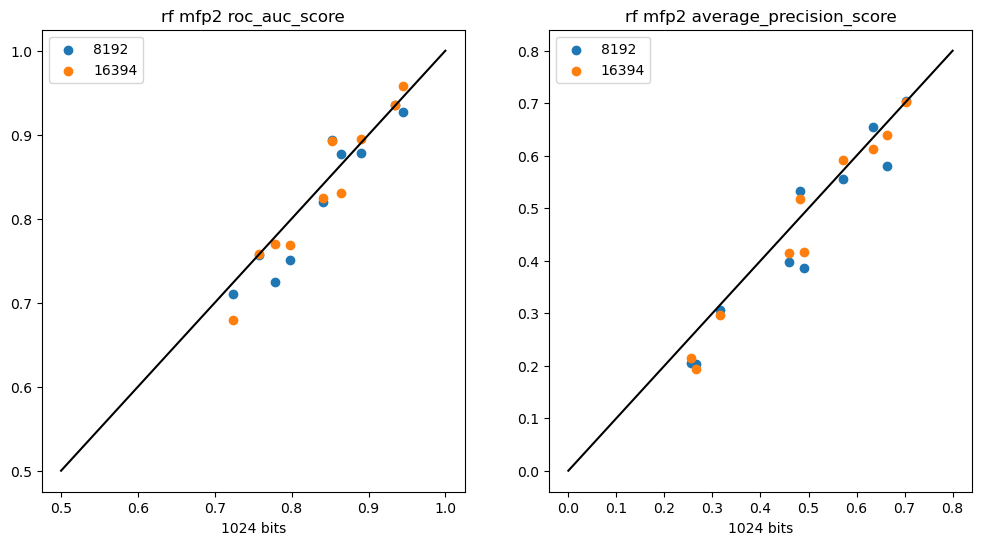

In [25]:
do_plots('rf','mfp2',accum)

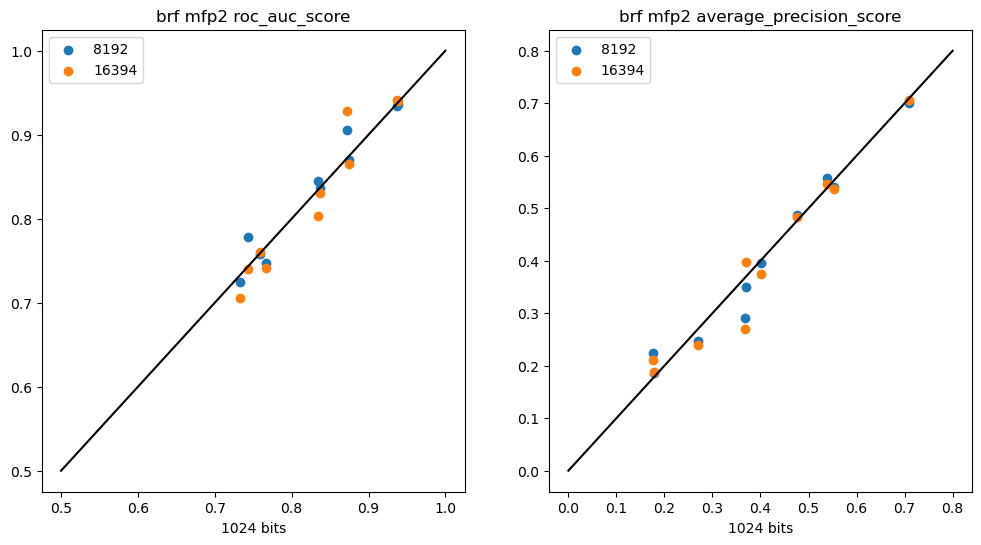

In [26]:
do_plots('brf','mfp2',accum)

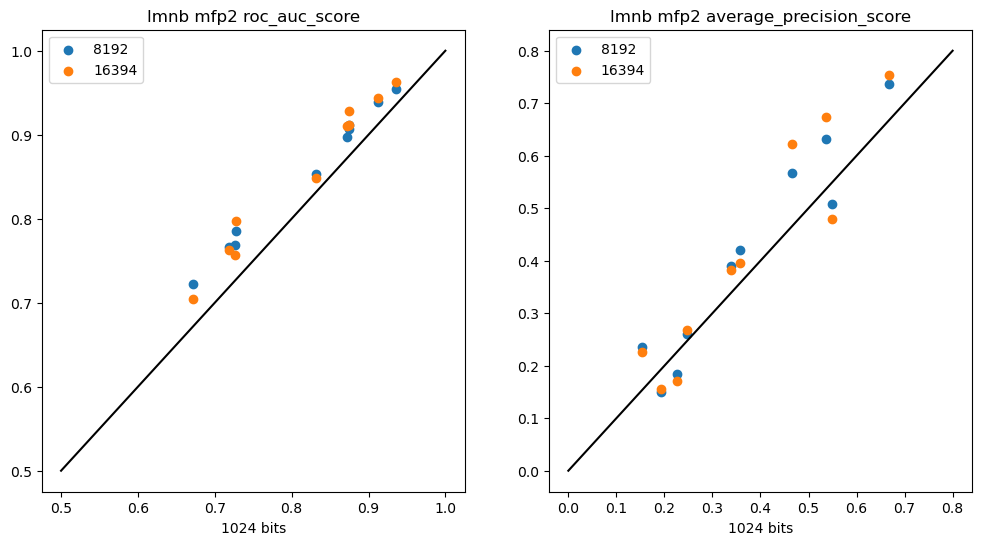

In [119]:
do_plots('lmnb','mfp2',accum)

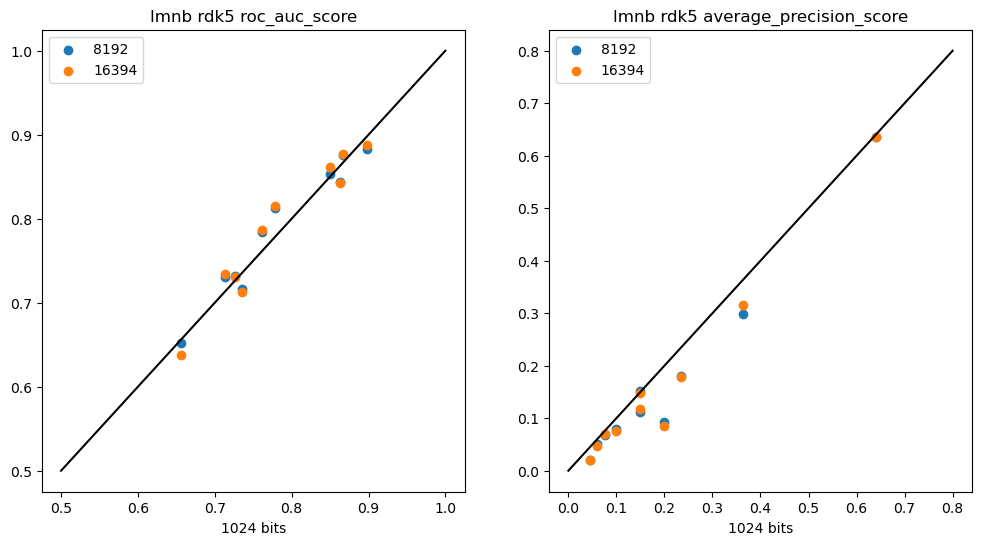

In [130]:
do_plots('lmnb','rdk5',accum)

# Where does FP size really make a difference?

In [128]:
from scipy import stats

In [143]:
def do_significance(alg,fp,size1=1024,size2=16394,
                    tableOutput=False,showHeader=False,pthresh=0.001,accum=accum,metrics=metrics):
  
    v1s = defaultdict(list)
    v2s = defaultdict(list)
    delts = defaultdict(list)
    pct_delts = defaultdict(list)

    if tableOutput and showHeader:
        row = ('alg','fp','metric','result','P','delt','pct_delt')
        divider = ['-'*len(k) for k in row]
        print('| '+' | '.join(row)+' |')
        print('| '+' | '.join(divider)+' |')
        
        
    res1 = accum[alg][f'{fp}-{size1}']
    res2 = accum[alg][f'{fp}-{size2}']
    
    for d1,d2 in zip(res1.values(),res2.values()):
        for metric in metrics:
            v1 = d1[metric]
            v2 = d2[metric]
            v1s[metric].append(v1)
            v2s[metric].append(v2)
            delt = v1-v2
            delts[metric].append(delt)
            pct_delts[metric].append(delt/v1)
    for metric in metrics:
        w2s = stats.wilcoxon(v1s[metric],v2s[metric],alternative='two-sided').pvalue
        wlt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='less').pvalue
        wgt = stats.wilcoxon(v1s[metric],v2s[metric],alternative='greater').pvalue
        result = 'same'
        which = w2s
        if wlt<pthresh or wgt<pthresh:
            if wlt < pthresh:
                result = 'lt'
                which = wlt
            elif wgt < pthresh:
                result = 'gt'
                which = wgt
        elif w2s<pthresh:
            result='diff'
        row = (alg,fp,metric,result,f'{which:.3g}',f'{np.median(delts[metric]):.2g}',f'{np.median(pct_delts[metric]):.3g}')
        if not tableOutput:
            print(' '.join(row))
        else:
            print('| '+' | '.join(row)+' |')

In [144]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,))
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 0.000977 | -0.035 | -0.0435 |
| lmnb | mfp3 | roc_auc_score | lt | 0.000977 | -0.048 | -0.0584 |
| lmnb | rdk5 | roc_auc_score | same | 0.695 | -0.0071 | -0.0088 |
| lmnb | hashap | roc_auc_score | same | 0.0371 | -0.011 | -0.0136 |
| lmnb | hashtt | roc_auc_score | same | 0.00977 | -0.043 | -0.0566 |
| rf | mfp2 | roc_auc_score | same | 0.492 | 0.0042 | 0.00537 |
| rf | mfp3 | roc_auc_score | same | 0.625 | 0.0035 | 0.00368 |
| rf | rdk5 | roc_auc_score | same | 0.375 | 0.0055 | 0.00687 |
| rf | hashap | roc_auc_score | same | 0.00391 | -0.015 | -0.0178 |
| rf | hashtt | roc_auc_score | same | 0.77 | -0.0016 | -0.00263 |
| brf | mfp2 | roc_auc_score | same | 0.322 | 0.0045 | 0.00562 |
| brf | mfp3 | roc_auc_score | same | 0.375 | -0.0021 | -0.00258 |
| brf | rdk5 | roc_auc_score | same | 0.105 | 0.014 | 0.0152 |
| brf | hashap 

Using the same threshold as before - P = 0.001 - we get few significant differences here. Given that we have way less repeats than we did in the previous analysis, let's swap to P = 0.01 and see what happens:

In [145]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,),
                           pthresh=0.01)
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 0.000977 | -0.035 | -0.0435 |
| lmnb | mfp3 | roc_auc_score | lt | 0.000977 | -0.048 | -0.0584 |
| lmnb | rdk5 | roc_auc_score | same | 0.695 | -0.0071 | -0.0088 |
| lmnb | hashap | roc_auc_score | same | 0.0371 | -0.011 | -0.0136 |
| lmnb | hashtt | roc_auc_score | lt | 0.00488 | -0.043 | -0.0566 |
| rf | mfp2 | roc_auc_score | same | 0.492 | 0.0042 | 0.00537 |
| rf | mfp3 | roc_auc_score | same | 0.625 | 0.0035 | 0.00368 |
| rf | rdk5 | roc_auc_score | same | 0.375 | 0.0055 | 0.00687 |
| rf | hashap | roc_auc_score | lt | 0.00195 | -0.015 | -0.0178 |
| rf | hashtt | roc_auc_score | same | 0.77 | -0.0016 | -0.00263 |
| brf | mfp2 | roc_auc_score | same | 0.322 | 0.0045 | 0.00562 |
| brf | mfp3 | roc_auc_score | same | 0.375 | -0.0021 | -0.00258 |
| brf | rdk5 | roc_auc_score | same | 0.105 | 0.014 | 0.0152 |
| brf | hashap | ro

And now render that

## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 0.000977 | -0.035 | -0.0435 |
| lmnb | mfp3 | roc_auc_score | lt | 0.000977 | -0.048 | -0.0584 |
| lmnb | rdk5 | roc_auc_score | same | 0.695 | -0.0071 | -0.0088 |
| lmnb | hashap | roc_auc_score | same | 0.0371 | -0.011 | -0.0136 |
| lmnb | hashtt | roc_auc_score | lt | 0.00488 | -0.043 | -0.0566 |
| rf | mfp2 | roc_auc_score | same | 0.492 | 0.0042 | 0.00537 |
| rf | mfp3 | roc_auc_score | same | 0.625 | 0.0035 | 0.00368 |
| rf | rdk5 | roc_auc_score | same | 0.375 | 0.0055 | 0.00687 |
| rf | hashap | roc_auc_score | lt | 0.00195 | -0.015 | -0.0178 |
| rf | hashtt | roc_auc_score | same | 0.77 | -0.0016 | -0.00263 |
| brf | mfp2 | roc_auc_score | same | 0.322 | 0.0045 | 0.00562 |
| brf | mfp3 | roc_auc_score | same | 0.375 | -0.0021 | -0.00258 |
| brf | rdk5 | roc_auc_score | same | 0.105 | 0.014 | 0.0152 |
| brf | hashap | roc_auc_score | same | 0.375 | -0.012 | -0.0163 |
| brf | hashtt | roc_auc_score | same | 0.492 | 0.0042 | 0.00477 |
| xgb | mfp2 | roc_auc_score | same | 0.625 | -0.0036 | -0.0042 |
| xgb | mfp3 | roc_auc_score | same | 0.0371 | -0.018 | -0.0217 |
| xgb | rdk5 | roc_auc_score | same | 0.625 | -0.0032 | -0.00386 |
| xgb | hashap | roc_auc_score | same | 0.322 | -0.022 | -0.0244 |
| xgb | hashtt | roc_auc_score | same | 0.432 | -0.028 | -0.0342 |



## average_precision_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | average_precision_score | same | 0.193 | -0.041 | -0.118 |
| lmnb | mfp3 | average_precision_score | same | 0.625 | -0.011 | -0.0267 |
| lmnb | rdk5 | average_precision_score | gt | 0.000977 | 0.025 | 0.21 |
| lmnb | hashap | average_precision_score | same | 0.695 | 0.00077 | 0.0369 |
| lmnb | hashtt | average_precision_score | same | 0.77 | -0.015 | -0.0687 |
| rf | mfp2 | average_precision_score | same | 0.0645 | 0.023 | 0.0473 |
| rf | mfp3 | average_precision_score | same | 0.193 | 0.017 | 0.0358 |
| rf | rdk5 | average_precision_score | same | 0.0371 | 0.034 | 0.054 |
| rf | hashap | average_precision_score | same | 0.557 | 0.0073 | 0.0254 |
| rf | hashtt | average_precision_score | same | 0.846 | -0.0027 | -0.0065 |
| brf | mfp2 | average_precision_score | same | 0.846 | -0.0024 | -0.00566 |
| brf | mfp3 | average_precision_score | same | 0.695 | 0.0054 | 0.00935 |
| brf | rdk5 | average_precision_score | same | 0.0371 | 0.054 | 0.098 |
| brf | hashap | average_precision_score | same | 0.0371 | 0.029 | 0.0944 |
| brf | hashtt | average_precision_score | same | 0.084 | 0.02 | 0.0574 |
| xgb | mfp2 | average_precision_score | same | 0.375 | -0.019 | -0.0288 |
| xgb | mfp3 | average_precision_score | same | 0.16 | -0.026 | -0.0502 |
| xgb | rdk5 | average_precision_score | same | 0.846 | -8.4e-06 | -0.0013 |
| xgb | hashap | average_precision_score | same | 0.084 | -0.032 | -0.0528 |
| xgb | hashtt | average_precision_score | same | 0.0371 | -0.03 | -0.057 |

Comparing 1K to 8K

In [149]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,),
                           pthresh=0.01,size2=8192)
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | lt | 0.000977 | -0.034 | -0.0394 |
| lmnb | mfp3 | roc_auc_score | lt | 0.000977 | -0.044 | -0.0529 |
| lmnb | rdk5 | roc_auc_score | same | 0.625 | -0.0039 | -0.00514 |
| lmnb | hashap | roc_auc_score | lt | 0.000977 | -0.017 | -0.0203 |
| lmnb | hashtt | roc_auc_score | lt | 0.00195 | -0.043 | -0.0552 |
| rf | mfp2 | roc_auc_score | same | 0.232 | 0.012 | 0.0153 |
| rf | mfp3 | roc_auc_score | same | 0.492 | 0.0049 | 0.00601 |
| rf | rdk5 | roc_auc_score | same | 0.492 | 0.0043 | 0.00477 |
| rf | hashap | roc_auc_score | same | 0.375 | -0.016 | -0.0182 |
| rf | hashtt | roc_auc_score | same | 0.492 | -0.0038 | -0.00464 |
| brf | mfp2 | roc_auc_score | same | 1 | 0.0018 | 0.00194 |
| brf | mfp3 | roc_auc_score | same | 0.375 | -0.011 | -0.0142 |
| brf | rdk5 | roc_auc_score | same | 0.105 | 0.011 | 0.0121 |
| brf | hashap | roc_auc_

Comparing 8K to 16K

In [148]:
metrics = ['roc_auc_score','average_precision_score']
for metric in metrics:
    print(f'## {metric}')
    for i,alg in enumerate(('lmnb','rf','brf','xgb')):
        for j,fp in enumerate(('mfp2','mfp3','rdk5','hashap','hashtt')):
            do_significance(alg,fp,tableOutput=True,showHeader=(not i + j),metrics=(metric,),
                           pthresh=0.01,size1=8192)
    print('\n\n')


## roc_auc_score
| alg | fp | metric | result | P | delt | pct_delt |
| --- | -- | ------ | ------ | - | ---- | -------- |
| lmnb | mfp2 | roc_auc_score | same | 0.492 | -0.0048 | -0.0052 |
| lmnb | mfp3 | roc_auc_score | same | 0.492 | -0.0044 | -0.00482 |
| lmnb | rdk5 | roc_auc_score | same | 0.625 | -0.0011 | -0.00129 |
| lmnb | hashap | roc_auc_score | same | 0.625 | 0.00048 | 0.000559 |
| lmnb | hashtt | roc_auc_score | same | 0.275 | -0.0019 | -0.00237 |
| rf | mfp2 | roc_auc_score | same | 0.625 | -0.0031 | -0.00382 |
| rf | mfp3 | roc_auc_score | same | 0.557 | -0.0064 | -0.00825 |
| rf | rdk5 | roc_auc_score | same | 0.922 | 0.009 | 0.0109 |
| rf | hashap | roc_auc_score | same | 1 | 0.003 | 0.00328 |
| rf | hashtt | roc_auc_score | same | 0.695 | 0.0045 | 0.00526 |
| brf | mfp2 | roc_auc_score | same | 0.322 | 0.0051 | 0.00643 |
| brf | mfp3 | roc_auc_score | same | 0.922 | 0.0015 | 0.0014 |
| brf | rdk5 | roc_auc_score | same | 0.322 | 0.0035 | 0.00426 |
| brf | hashap | ro